# Experiment 1

### Two point crossover

* Run 1

In [3]:
#!pip install opencv-python-headless

In [1]:
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGBA", (self._img_width, self._img_height), (255, 255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image.convert('L'))
    rendered_image = np.array(painting.draw().convert('L'))
    ssim_value = ssim(target_array, rendered_image)
    return 1 - ssim_value

def two_point_crossover(parent1, parent2):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    point1 = random.randint(0, len(parent1.triangles) - 1)
    point2 = random.randint(point1, len(parent1.triangles))

    child1.triangles[point1:point2], child2.triangles[point1:point2] = parent2.triangles[point1:point2], parent1.triangles[point1:point2]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = two_point_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

population_size = 50
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

C:\Users\barbara\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Run 1
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 77  77  77]
 [167 167 167]
 [119  66   0]
 [212 212 212]
 [ 38  33  27]
 [122 122 122]
 [223 123   0]]
Generation 1, Best Fitness: 0.33006428831085644
Generation 2, Best Fitness: 0.3270422097125093
Generation 3, Best Fitness: 0.3251590836029328
Generation 4, Best Fitness: 0.3220135058528587
Generation 5, Best Fitness: 0.31693612800193016
Generation 6, Best Fitness: 0.3147518057446109
Generation 7, Best Fitness: 0.3147381450529505
Generation 8, Best Fitness: 0.3141358676186684
Generation 9, Best Fitness: 0.31384025096597645
Generation 10, Best Fitness: 0.31271929481225624
Generation 11, Best Fitness: 0.31242429356583723
Generation 12, Best Fitness: 0.3118229161830536
Generation 13, Best Fitness: 0.3107426406195456
Generation 14, Best Fitness: 0.30953028461319554
Generation 15, Best Fitness: 0.30951310054462167
Generation 16, Best Fitness: 0.30935571109614535
Generation 17, Best Fitness: 0.3080497597048929
Generatio

Generation 165, Best Fitness: 0.21911762912910637
Generation 166, Best Fitness: 0.21866542335122952
Generation 167, Best Fitness: 0.2186110414196195
Generation 168, Best Fitness: 0.2173367222322491
Generation 169, Best Fitness: 0.2173367222322491
Generation 170, Best Fitness: 0.2173367222322491
Generation 171, Best Fitness: 0.21694037550995127
Generation 172, Best Fitness: 0.21694037550995127
Generation 173, Best Fitness: 0.2165975608921673
Generation 174, Best Fitness: 0.2163014471366167
Generation 175, Best Fitness: 0.21599786465505888
Generation 176, Best Fitness: 0.21599786465505888
Generation 177, Best Fitness: 0.21529492208443857
Generation 178, Best Fitness: 0.2152261460109014
Generation 179, Best Fitness: 0.21341612802293897
Generation 180, Best Fitness: 0.21287315677158436
Generation 181, Best Fitness: 0.21099598904445938
Generation 182, Best Fitness: 0.21018912647043486
Generation 183, Best Fitness: 0.206298725597149
Generation 184, Best Fitness: 0.206298725597149
Generation 

Generation 330, Best Fitness: 0.1409083114856532
Generation 331, Best Fitness: 0.14088457249271158
Generation 332, Best Fitness: 0.14000721348943557
Generation 333, Best Fitness: 0.14000474737373492
Generation 334, Best Fitness: 0.1399832789414852
Generation 335, Best Fitness: 0.1399832789414852
Generation 336, Best Fitness: 0.1399832789414852
Generation 337, Best Fitness: 0.13908340131884944
Generation 338, Best Fitness: 0.13908340131884944
Generation 339, Best Fitness: 0.1390536497917384
Generation 340, Best Fitness: 0.1390536497917384
Generation 341, Best Fitness: 0.13812587490708583
Generation 342, Best Fitness: 0.13809425188193925
Generation 343, Best Fitness: 0.13757847524891853
Generation 344, Best Fitness: 0.13753821566975344
Generation 345, Best Fitness: 0.13659731982457934
Generation 346, Best Fitness: 0.13659731982457934
Generation 347, Best Fitness: 0.13604057393707447
Generation 348, Best Fitness: 0.13604057393707447
Generation 349, Best Fitness: 0.13604057393707447
Genera

Generation 495, Best Fitness: 0.11463304273169095
Generation 496, Best Fitness: 0.11463304273169095
Generation 497, Best Fitness: 0.11463304273169095
Generation 498, Best Fitness: 0.11461644373030344
Generation 499, Best Fitness: 0.11461644373030344
Generation 500, Best Fitness: 0.11459412442642758


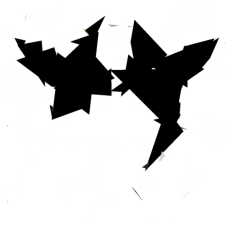

In [2]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 2

In [1]:
for run in range(1):
    print(f"Run {run + 2}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 2
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [113 113 113]
 [210 210 210]
 [119  66   0]
 [160 160 160]
 [ 71  71  71]
 [223 123   0]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.32835717822887955
Generation 2, Best Fitness: 0.32818414708815435
Generation 3, Best Fitness: 0.3248881389190159
Generation 4, Best Fitness: 0.32167166896595334
Generation 5, Best Fitness: 0.32154022216215083
Generation 6, Best Fitness: 0.3200284952167153
Generation 7, Best Fitness: 0.3188610381038478
Generation 8, Best Fitness: 0.3188610381038478
Generation 9, Best Fitness: 0.3183067569884235
Generation 10, Best Fitness: 0.31723054597613054
Generation 11, Best Fitness: 0.31686392602017077
Generation 12, Best Fitness: 0.3149930979400971
Generation 13, Best Fitness: 0.31458012220694187
Generation 14, Best Fitness: 0.31458012220694187
Generation 15, Best Fitness: 0.31142796461685984
Generation 16, Best Fitness: 0.31142796461685984
Generation 17, Best Fitness: 0.31103688779382566
Genera

Generation 165, Best Fitness: 0.2196218384132118
Generation 166, Best Fitness: 0.21868304965336316
Generation 167, Best Fitness: 0.21868304965336316
Generation 168, Best Fitness: 0.21628894082539463
Generation 169, Best Fitness: 0.21477204814521478
Generation 170, Best Fitness: 0.21477204814521478
Generation 171, Best Fitness: 0.2118555891146996
Generation 172, Best Fitness: 0.21116989512710194
Generation 173, Best Fitness: 0.2110980482431679
Generation 174, Best Fitness: 0.21014698644438945
Generation 175, Best Fitness: 0.21014698644438945
Generation 176, Best Fitness: 0.20938888958442836
Generation 177, Best Fitness: 0.20938888958442836
Generation 178, Best Fitness: 0.20929229934997173
Generation 179, Best Fitness: 0.2092901086682185
Generation 180, Best Fitness: 0.2092620627712789
Generation 181, Best Fitness: 0.20878603542269003
Generation 182, Best Fitness: 0.20760597746542697
Generation 183, Best Fitness: 0.20755498762772762
Generation 184, Best Fitness: 0.2069911043234709
Genera

Generation 330, Best Fitness: 0.14460918586427984
Generation 331, Best Fitness: 0.1445536393674559
Generation 332, Best Fitness: 0.14433287618322832
Generation 333, Best Fitness: 0.14433287618322832
Generation 334, Best Fitness: 0.144172655576991
Generation 335, Best Fitness: 0.144172655576991
Generation 336, Best Fitness: 0.144172655576991
Generation 337, Best Fitness: 0.14411817399580074
Generation 338, Best Fitness: 0.14392420491356317
Generation 339, Best Fitness: 0.1439192952873274
Generation 340, Best Fitness: 0.14391892212438684
Generation 341, Best Fitness: 0.1430232832609969
Generation 342, Best Fitness: 0.1430232832609969
Generation 343, Best Fitness: 0.1430151914049822
Generation 344, Best Fitness: 0.1430151914049822
Generation 345, Best Fitness: 0.14298922213650167
Generation 346, Best Fitness: 0.14282171024365786
Generation 347, Best Fitness: 0.1421064686606126
Generation 348, Best Fitness: 0.14124463148078548
Generation 349, Best Fitness: 0.14124463148078548
Generation 35

Generation 495, Best Fitness: 0.11627664540138949
Generation 496, Best Fitness: 0.1157463576348865
Generation 497, Best Fitness: 0.1157463576348865
Generation 498, Best Fitness: 0.1157463576348865
Generation 499, Best Fitness: 0.11568357004072427
Generation 500, Best Fitness: 0.11547587744919108


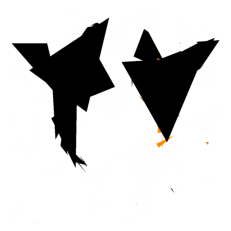

In [3]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 3

In [4]:
for run in range(1):
    print(f"Run {run + 3}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 3
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [113 113 113]
 [210 210 210]
 [ 71  71  71]
 [160 160 160]
 [119  66   0]
 [223 123   0]
 [ 36  30  24]]
Generation 1, Best Fitness: 0.3300745488982767
Generation 2, Best Fitness: 0.32616931628996226
Generation 3, Best Fitness: 0.3208590385569622
Generation 4, Best Fitness: 0.3208590385569622
Generation 5, Best Fitness: 0.320068250303434
Generation 6, Best Fitness: 0.3156366360616719
Generation 7, Best Fitness: 0.31462627811518695
Generation 8, Best Fitness: 0.3135321301970554
Generation 9, Best Fitness: 0.3116106714553326
Generation 10, Best Fitness: 0.3104335064163021
Generation 11, Best Fitness: 0.3101627702448869
Generation 12, Best Fitness: 0.31006675027863007
Generation 13, Best Fitness: 0.31006675027863007
Generation 14, Best Fitness: 0.3096222027740594
Generation 15, Best Fitness: 0.30955258449608536
Generation 16, Best Fitness: 0.30889839785943096
Generation 17, Best Fitness: 0.3078956051801497
Generation 1

Generation 166, Best Fitness: 0.22786043081571694
Generation 167, Best Fitness: 0.22663270917088807
Generation 168, Best Fitness: 0.22663270917088807
Generation 169, Best Fitness: 0.22663270917088807
Generation 170, Best Fitness: 0.22616859346573615
Generation 171, Best Fitness: 0.2259702954536439
Generation 172, Best Fitness: 0.22510069135351296
Generation 173, Best Fitness: 0.2248892609520916
Generation 174, Best Fitness: 0.2248471654526072
Generation 175, Best Fitness: 0.22433064576968464
Generation 176, Best Fitness: 0.22427018572657897
Generation 177, Best Fitness: 0.2242372993619306
Generation 178, Best Fitness: 0.2235525035779925
Generation 179, Best Fitness: 0.22325045912811625
Generation 180, Best Fitness: 0.22271032896911735
Generation 181, Best Fitness: 0.22221648091242674
Generation 182, Best Fitness: 0.2222164647436975
Generation 183, Best Fitness: 0.22202717385598314
Generation 184, Best Fitness: 0.22185520444133444
Generation 185, Best Fitness: 0.22136082561920312
Genera

Generation 331, Best Fitness: 0.15687869090652473
Generation 332, Best Fitness: 0.15574973000549241
Generation 333, Best Fitness: 0.15574872300085485
Generation 334, Best Fitness: 0.15566056036849862
Generation 335, Best Fitness: 0.15566056036849862
Generation 336, Best Fitness: 0.15419673703389836
Generation 337, Best Fitness: 0.15419673703389836
Generation 338, Best Fitness: 0.15359627013784283
Generation 339, Best Fitness: 0.15359627013784283
Generation 340, Best Fitness: 0.15355891509199637
Generation 341, Best Fitness: 0.15339202458656587
Generation 342, Best Fitness: 0.15339202458656587
Generation 343, Best Fitness: 0.15335081759541325
Generation 344, Best Fitness: 0.1531854683614704
Generation 345, Best Fitness: 0.15303977143959102
Generation 346, Best Fitness: 0.15235121322184564
Generation 347, Best Fitness: 0.15235121322184564
Generation 348, Best Fitness: 0.1518673861944495
Generation 349, Best Fitness: 0.15153660885725329
Generation 350, Best Fitness: 0.15153660885725329
Ge

Generation 496, Best Fitness: 0.13153928252019786
Generation 497, Best Fitness: 0.1315347513141194
Generation 498, Best Fitness: 0.13147451785331543
Generation 499, Best Fitness: 0.1314743990102406
Generation 500, Best Fitness: 0.13109085767674045


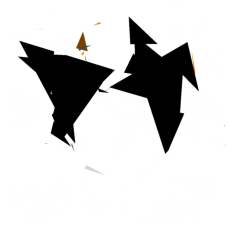

In [5]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 4

In [2]:
for run in range(1):
    print(f"Run {run + 4}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 4
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [164 164 164]
 [ 73  73  73]
 [119  66   0]
 [212 212 212]
 [ 37  31  24]
 [223 123   0]
 [117 117 117]]
Generation 1, Best Fitness: 0.32633387845538575
Generation 2, Best Fitness: 0.32456445982134263
Generation 3, Best Fitness: 0.32102563486543056
Generation 4, Best Fitness: 0.32102563486543056
Generation 5, Best Fitness: 0.31865729021270517
Generation 6, Best Fitness: 0.3182920813725876
Generation 7, Best Fitness: 0.3182920813725876
Generation 8, Best Fitness: 0.3150577286297829
Generation 9, Best Fitness: 0.3143724817349054
Generation 10, Best Fitness: 0.31401234480563345
Generation 11, Best Fitness: 0.3130204145297599
Generation 12, Best Fitness: 0.3114713883076514
Generation 13, Best Fitness: 0.3114713883076514
Generation 14, Best Fitness: 0.310961360279546
Generation 15, Best Fitness: 0.3100153421843935
Generation 16, Best Fitness: 0.3100153421843935
Generation 17, Best Fitness: 0.3082698210653977
Generation 1

Generation 166, Best Fitness: 0.22616704149054256
Generation 167, Best Fitness: 0.22580368128118256
Generation 168, Best Fitness: 0.22501524531227823
Generation 169, Best Fitness: 0.2248678094777662
Generation 170, Best Fitness: 0.22389396371020742
Generation 171, Best Fitness: 0.22249051309264156
Generation 172, Best Fitness: 0.221681365634806
Generation 173, Best Fitness: 0.22097774143441418
Generation 174, Best Fitness: 0.2206325285073859
Generation 175, Best Fitness: 0.22016094894385907
Generation 176, Best Fitness: 0.22016079140378864
Generation 177, Best Fitness: 0.2198755261292511
Generation 178, Best Fitness: 0.21966461714559593
Generation 179, Best Fitness: 0.21927735819533978
Generation 180, Best Fitness: 0.2189187696865067
Generation 181, Best Fitness: 0.21887511489777356
Generation 182, Best Fitness: 0.21801475321151176
Generation 183, Best Fitness: 0.21755508139851487
Generation 184, Best Fitness: 0.21728421595974223
Generation 185, Best Fitness: 0.2163584088491045
Generat

Generation 331, Best Fitness: 0.13607631385571395
Generation 332, Best Fitness: 0.13607631385571395
Generation 333, Best Fitness: 0.13531040495157542
Generation 334, Best Fitness: 0.13391582601291263
Generation 335, Best Fitness: 0.13389749458515332
Generation 336, Best Fitness: 0.13380467787726547
Generation 337, Best Fitness: 0.1336797912613582
Generation 338, Best Fitness: 0.1335455450701497
Generation 339, Best Fitness: 0.1335455450701497
Generation 340, Best Fitness: 0.13354273031528008
Generation 341, Best Fitness: 0.133535368048472
Generation 342, Best Fitness: 0.13291900791162792
Generation 343, Best Fitness: 0.13291900791162792
Generation 344, Best Fitness: 0.1326708082883249
Generation 345, Best Fitness: 0.1326708082883249
Generation 346, Best Fitness: 0.1326679184129208
Generation 347, Best Fitness: 0.13251240904303108
Generation 348, Best Fitness: 0.13234800169025196
Generation 349, Best Fitness: 0.13234800169025196
Generation 350, Best Fitness: 0.13228132696486838
Generati

Generation 496, Best Fitness: 0.10964084342544833
Generation 497, Best Fitness: 0.10958618834219713
Generation 498, Best Fitness: 0.10958618834219713
Generation 499, Best Fitness: 0.10937797903241375
Generation 500, Best Fitness: 0.10917202169277707


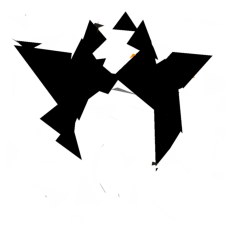

In [4]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

* Run 5 

In [5]:
for run in range(1):
    print(f"Run {run + 5}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 5
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [108 108 108]
 [123  68   0]
 [148 148 148]
 [188 188 188]
 [ 36  30  24]
 [226 226 226]
 [ 70  70  70]]
Generation 1, Best Fitness: 0.32982949472616174
Generation 2, Best Fitness: 0.32493295430126556
Generation 3, Best Fitness: 0.3226432969520039
Generation 4, Best Fitness: 0.3206663166673107
Generation 5, Best Fitness: 0.32019736465052706
Generation 6, Best Fitness: 0.3196430509681274
Generation 7, Best Fitness: 0.3179985744443343
Generation 8, Best Fitness: 0.31741594506998316
Generation 9, Best Fitness: 0.3153328984269239
Generation 10, Best Fitness: 0.31527944103728767
Generation 11, Best Fitness: 0.31445756627673116
Generation 12, Best Fitness: 0.3132798226494714
Generation 13, Best Fitness: 0.31308616205296746
Generation 14, Best Fitness: 0.3123569493069981
Generation 15, Best Fitness: 0.31091108305830784
Generation 16, Best Fitness: 0.31091108305830784
Generation 17, Best Fitness: 0.3108215279092391
Generati

Generation 166, Best Fitness: 0.23955057889622433
Generation 167, Best Fitness: 0.23888412085242183
Generation 168, Best Fitness: 0.2371291212871548
Generation 169, Best Fitness: 0.2369969925663462
Generation 170, Best Fitness: 0.23583462594689053
Generation 171, Best Fitness: 0.23583444859719738
Generation 172, Best Fitness: 0.23534143555568554
Generation 173, Best Fitness: 0.2353325064617704
Generation 174, Best Fitness: 0.23515274049036494
Generation 175, Best Fitness: 0.2346441350098598
Generation 176, Best Fitness: 0.23338075410251513
Generation 177, Best Fitness: 0.23338075410251513
Generation 178, Best Fitness: 0.23332080829599733
Generation 179, Best Fitness: 0.2329605111921288
Generation 180, Best Fitness: 0.2327890214787156
Generation 181, Best Fitness: 0.23059595810757416
Generation 182, Best Fitness: 0.23044738106441842
Generation 183, Best Fitness: 0.22906112707156068
Generation 184, Best Fitness: 0.22837639361408646
Generation 185, Best Fitness: 0.22837639361408646
Genera

Generation 331, Best Fitness: 0.1392458348170993
Generation 332, Best Fitness: 0.13898058018304926
Generation 333, Best Fitness: 0.13888715406715757
Generation 334, Best Fitness: 0.13878336762499988
Generation 335, Best Fitness: 0.13863987546629875
Generation 336, Best Fitness: 0.13792675690214762
Generation 337, Best Fitness: 0.137595018297061
Generation 338, Best Fitness: 0.137595018297061
Generation 339, Best Fitness: 0.1375672998200228
Generation 340, Best Fitness: 0.1374657642866548
Generation 341, Best Fitness: 0.13675596806124235
Generation 342, Best Fitness: 0.13675596806124235
Generation 343, Best Fitness: 0.13649187523462591
Generation 344, Best Fitness: 0.13558004448140937
Generation 345, Best Fitness: 0.13558004448140937
Generation 346, Best Fitness: 0.13519917222335343
Generation 347, Best Fitness: 0.13519917222335343
Generation 348, Best Fitness: 0.1351215728941847
Generation 349, Best Fitness: 0.13469440042269765
Generation 350, Best Fitness: 0.13429406126171983
Generati

Generation 496, Best Fitness: 0.10302289717655877
Generation 497, Best Fitness: 0.10302289717655877
Generation 498, Best Fitness: 0.10301969237906872
Generation 499, Best Fitness: 0.10295245252764007
Generation 500, Best Fitness: 0.10199906898842859


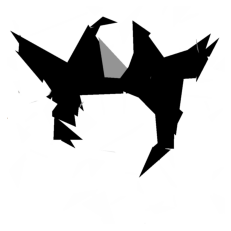

In [6]:
best_individual = population.individuals[population.fitness.index(min(population.fitness))]

best_image = best_individual.draw()

best_image_array = np.array(best_image)

plt.imshow(best_image_array)
plt.axis('off')  
plt.show()

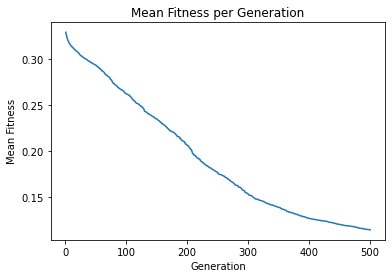

In [13]:
fitness_file = "fitness_values_2PC.txt"

with open(fitness_file, "r") as file:
    fitness_values = [float(line.strip()) for line in file]

num_generations_per_run = 500
num_runs = len(fitness_values) // num_generations_per_run

fitness_values = np.array(fitness_values)
fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

mean_fitness_per_generation = np.mean(fitness_values, axis=0)

plt.plot(range(1, num_generations_per_run + 1), mean_fitness_per_generation)
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Mean Fitness per Generation')
plt.show()
